# Cross-View Semantic Transformation: Deep Learning Approaches for Bird's Eye View Generation

## CS5330 Pattern Recognition & Computer Vision

### Final Project Report

This project explores the challenging task of transforming multiple front-facing camera perspectives into an accurate Bird's Eye View (BEV) representation using deep learning approaches. The BEV transformation is crucial for autonomous driving systems, providing a comprehensive top-down understanding of the vehicle's surroundings.

**Project Overview**

this is our enhanced implementation where we incroporarte Global Avg Pooling with self attention instead of concatenation

## Imports

In [1]:
!pip install torchgeometry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 1.7 MB/s eta 0:00:00


In [ ]:
import os
import sys
import cv2
import numpy as np
sys.path.append('/data/input/cam2bev-frlr/cam2bev-data-master')
import matplotlib.pyplot as plt

## DL imports
import torch
import torch.nn as nn

Notice how with data, we're able to download the dataset only once, and then "plug" to it on the right immediately. To make sure it works, you should write the write path though.

## 1. Data
We'll be using the [Cam2BEV dataset](https://gitlab.ika.rwth-aachen.de/cam2bev/cam2bev-data) from [Sim2Real paper](https://browse.arxiv.org/pdf/2005.04078.pdf). It consists of Semantically Segmented images from Front, Rear, Left and Right cameras and corresponding BEV images. So, each image has been put to a segmentation model, and we use that as input, our label is a Bird Eye View image. Let's load and visualize it all.

In [ ]:
dataRootDir = '/data/input/cam2bev-frlr/cam2bev-data-master/1_FRLR'
trainDir = os.path.join(dataRootDir, *['train'])
valDir = os.path.join(dataRootDir, *['val'])
examplesDir = os.path.join(dataRootDir, *['examples'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_image(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

frontImg = load_image(os.path.join(examplesDir, *['front.png']))
leftImg = load_image(os.path.join(examplesDir, *['left.png']))
rearImg = load_image(os.path.join(examplesDir, *['rear.png']))
rightImg = load_image(os.path.join(examplesDir, *['right.png']))
bevImg = load_image(os.path.join(examplesDir, *['bev.png']))
bevOccImg = load_image(os.path.join(examplesDir, *['bev+occlusion.png']))

print(frontImg.shape)

(604, 964, 3)


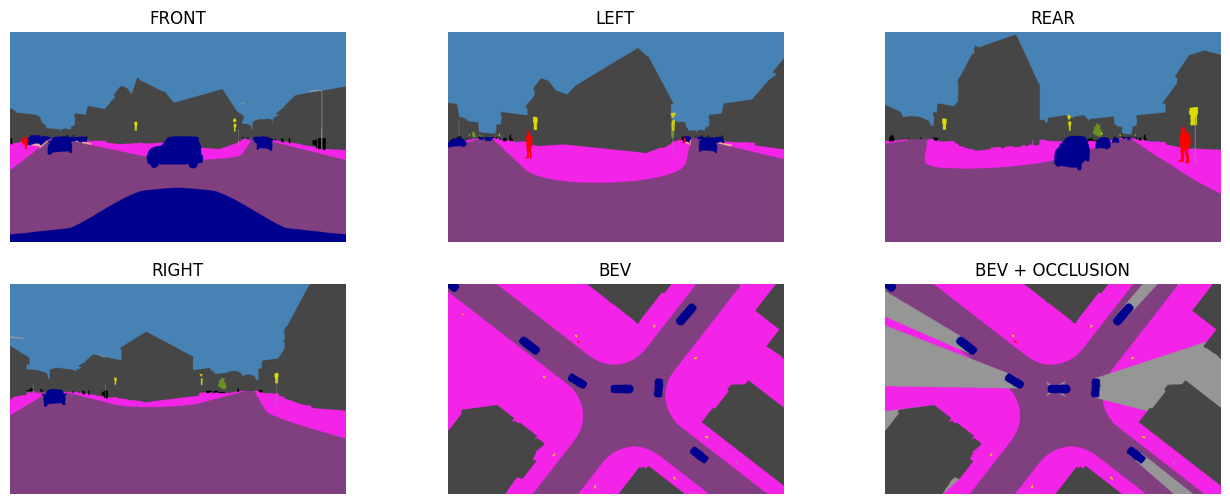

In [4]:
imageList = [frontImg, leftImg, rearImg, rightImg, bevImg, bevOccImg]
titlesList = ['FRONT', 'LEFT', 'REAR', 'RIGHT', 'BEV', 'BEV + OCCLUSION']

# function to plot single image
def plotImage(ax, img, title):
    imgHandle = ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')
    return imgHandle

fig, axes = plt.subplots(2,3, figsize= (16, 6))
for (ax,img,title) in zip(axes.flatten(), imageList, titlesList):
    plotImage(ax, img, title)
plt.show()

**Quick Note** Our examples are in PNG format, but the actual dataset is in NPY format (numPy), which is much lighter and easier to compress.

In [ ]:
"""
Palette Mapping**  The colors on the image correspond to 30 classes in [Cityscapes dataset](https://www.cityscapes-dataset.com/). We'll need to convert the RGB image to One-hot encoded image. We'll need a color -> Class mapping which is defined as follows. 
- For the Input image, we'll group 30 classes to 10 classes in the input palette.
- For the Output image, we'll group 30 classes to 10 classes (including Occlusion as the 10th class) in the output palette.
"""


inputPalette = [
    [np.array([128,  64, 128])],                                                       # road  
    [np.array([244,  35, 232]), np.array([250, 170, 160])],                            # sidewalk
    [np.array([255,   0,   0])],                                                       # person   
    [np.array([32, 47, 70]), np.array([  0,   0, 142]), np.array([  0,   0, 110])],                            # car
    [np.array([ 0,  0, 70])],                                                          # Truck
    [np.array([  0,  60, 100]), np.array([ 0,  0, 90])],                               # Bus
    [np.array([220,  20,  60]), np.array([  0,   0, 230]), np.array([119,  11,  32])], # Two-wheelers
    [np.array([0, 0, 0]), np.array([111,  74,   0]), np.array([81,  0, 81]),           # static obstacles
    np.array([230, 150, 140]), np.array([70, 70, 70]), np.array([102, 102, 156]),      
    np.array([190, 153, 153]), np.array([180, 165, 180]), np.array([150, 100, 100]),   
    np.array([150, 120,  90]), np.array([153, 153, 153]), np.array([153, 153, 153]),
    np.array([250, 170,  30]), np.array([220, 220,   0]), np.array([  0,  80, 100])],
    [np.array([152, 251, 152]),np.array([107, 142,  35])],                            # Vegetation
    [np.array([ 70, 130, 180])]                                                        # Sky
]


# Sky is added to Static obstacles and Occlusion is added as 10th class
outputPalette = [
    [np.array([128,  64, 128])],
    [np.array([244,  35, 232]), np.array([250, 170, 160])],
    [np.array([255,   0,   0])],
    [np.array([  0,   0, 142]), np.array([  0,   0, 110])],
    [np.array([ 0,  0, 70])],
    [np.array([  0,  60, 100]), np.array([ 0,  0, 90])],
    [np.array([220,  20,  60]), np.array([  0,   0, 230]), np.array([119,  11,  32])],
    [np.array([0, 0, 0]), np.array([111,  74,   0]), np.array([81,  0, 81]),
     np.array([230, 150, 140]), np.array([70, 70, 70]), np.array([102, 102, 156]),
     np.array([190, 153, 153]), np.array([180, 165, 180]), np.array([150, 100, 100]),
     np.array([150, 120,  90]), np.array([153, 153, 153]), np.array([153, 153, 153]),
     np.array([250, 170,  30]), np.array([220, 220,   0]), np.array([  0,  80, 100]), np.array([ 70, 130, 180])],
    [np.array([107, 142,  35]), np.array([152, 251, 152])], 
    [np.array([150, 150, 150])]              # OCCLUSION CLASS
]

So now, let's visualize our NUMPY images, with this palette:

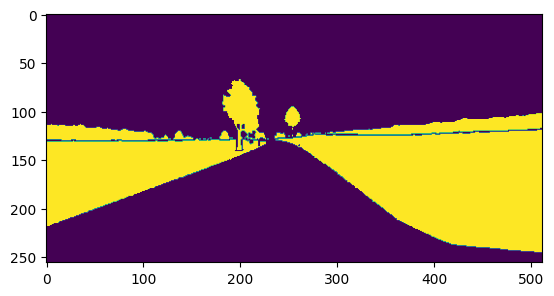

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
image_test_front = np.load((os.path.join(trainDir,"front/t_0_0_0004000.npy"))).astype(np.float32)
plt.imshow(image_test_front[8])
plt.show()
print(image_test_front[8])

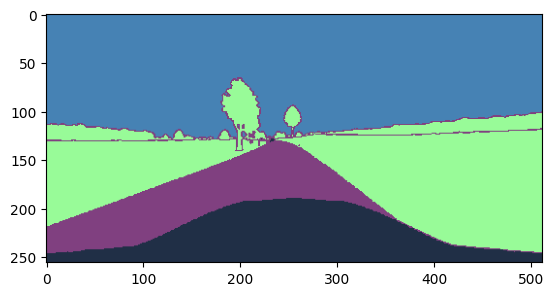

In [7]:
import utils
image_view_front = utils.one_hot_decode_image(image_test_front, inputPalette)
plt.imshow(image_view_front)
plt.show()

In [8]:
import utils  # module contains utility functions suchs as One hot encoding, resizing image 
from torch.utils.data import Dataset

class Cam2BEVDataset(Dataset):
    def __init__(self, input_dirs, label_dir):
        self.input_dirs = input_dirs
        self.label_dir = label_dir
        self.images = sorted(os.listdir(input_dirs[0]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        inputs = []
        
        # Load One hot encoded image 
        # Input = [Front, Left, Rear, Right]
        for i in self.input_dirs:
            oh_image_path = os.path.join(i, self.images[idx])
            image = np.load(oh_image_path).astype(np.float32)
            inputs.append(torch.from_numpy(image))
        
        # Label image => Load image -> One hot encode
        label_path = os.path.join(self.label_dir, self.images[idx])
        label = np.load(label_path).astype(np.float32)
        label = torch.from_numpy(label)
        return (inputs, label)

In [9]:
trainInputDirs = [os.path.join(trainDir,x) for x in ['front', 'left', 'rear', 'right']]
trainLabelDir = os.path.join(trainDir, *['bev+occlusion'])
trainSet = Cam2BEVDataset(trainInputDirs, trainLabelDir)

# Visualize Random sample
inputImages, bevLabelImg = trainSet[np.random.randint(0, len(trainSet))]
print(f"There are {len(inputImages)} input images,")
print(f"Single input image shape = {inputImages[0].shape}, Label image shape = {bevLabelImg.shape}")

There are 4 input images,
Single input image shape = torch.Size([10, 256, 512]), Label image shape = torch.Size([10, 256, 512])


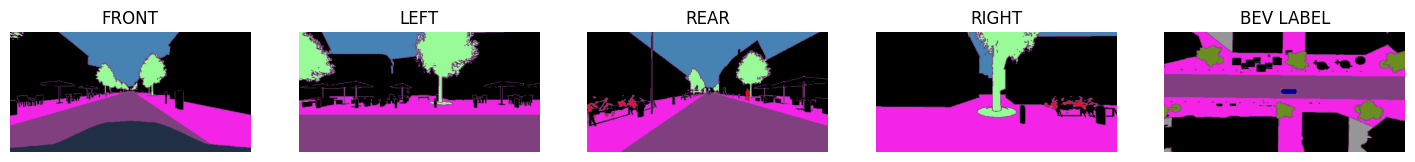

In [10]:
fig, axes = plt.subplots(1, 5, figsize= (18, 12))

# plot Input images
for (ax,img,title) in zip(axes.flatten(), inputImages, ['FRONT', 'LEFT', 'REAR', 'RIGHT']):
    rgbImage = utils.one_hot_decode_image(img.detach().numpy(), inputPalette)
    plotImage(ax, rgbImage, title)

# plot label image
bevRgbImg = utils.one_hot_decode_image(bevLabelImg.detach().numpy(), outputPalette)
plotImage(axes.flatten()[-1], bevRgbImg, 'BEV LABEL')
plt.show()

In [11]:
# Create Validation dataset
valInputDirs = [os.path.join(valDir,x) for x in ['front', 'left', 'rear', 'right']]
valLabelDir = os.path.join(valDir, *['bev+occlusion'])
valSet = Cam2BEVDataset(valInputDirs, valLabelDir)
print(f"There are {len(valSet)} validation images")

There are 500 validation images


In [12]:
### CREATE PYTORCH DATALOADERS
from torch.utils.data import DataLoader
trainLoader = DataLoader(trainSet, batch_size=4, shuffle=True, num_workers=2)
valLoader = DataLoader(valSet, batch_size=8, shuffle=False, num_workers=2)

## Model



In [13]:
class Encoder(nn.Module):
    def __init__(self, inputShape, u_depth, filters1):
        super(Encoder, self).__init__()
        # We define the depth we want to use
        self.u_depth = u_depth
        # We create a structure for our layers
        self.encoder_layers = nn.ModuleList()
        # We define the input filters
        filters = inputShape[-3]
        # And the output filters
        filters_ = filters1
        
        # For each "layer", we implement our block - the filters are dynamic
        for d in range(self.u_depth):
            layer = nn.Sequential(
                nn.Conv2d(filters, filters_, kernel_size=3, padding=1),
                nn.BatchNorm2d(filters_),
                nn.ReLU(True),                
                nn.Conv2d(filters_, filters_, kernel_size=3, padding=1),
                nn.BatchNorm2d(filters_),
                nn.ReLU(True),                
            )
            
            # If we're not at the last layer, we add Maxpooling.
            if d<(self.u_depth-1):
                layer.append(nn.MaxPool2d(kernel_size=2, stride=2))
                layer.append(nn.Dropout2d(p=0.1))
            
            # We then adjust our filters to go deeper at the next layer
            filters = filters_
            filters_ = (2**(d+1))*filters1
            
            # We add the layer to our structure
            self.encoder_layers.append(layer)

    def forward(self, x):
        # We define our layers
        encoder_layers = []
        # We create an intermediate buffer not to modify our input
        t = x
        
        # For each layer
        for d in range(self.u_depth):
            # if it's not the last layer
            if d<(self.u_depth-1):
                # Apply all but the last 2 operations (MaxPool & Dropout)
                t = self.encoder_layers[d][:-2](t)
                # Store the output so Spatial Transformers use it
                encoder_layers.append(t)
                # We then apply these last 2 operations
                t = self.encoder_layers[d][-2:](t)
            else:
                # The last layer doesn't have Maxpool & Dropout, so we apply all.
                t = self.encoder_layers[d](t)
                encoder_layers.append(t)

        return encoder_layers

In [14]:
encoderModule = Encoder(inputShape=(10,256,512), u_depth=4, filters1=16).to(device)

# Generate sample data, assuming batchsize of 1
# singleCameraData = torch.rand(1, 10, 256, 512).to(device)
singleCameraData = inputImages[0].unsqueeze(0).to(device)
encoderOutput = encoderModule(singleCameraData)
print(f"Len of encoderOutput = {len(encoderOutput)}")
print(f"Encoder outputs = {[x.shape for x in encoderOutput]}")

Len of encoderOutput = 4
Encoder outputs = [torch.Size([1, 16, 256, 512]), torch.Size([1, 32, 128, 256]), torch.Size([1, 64, 64, 128]), torch.Size([1, 128, 32, 64])]


In [15]:
print(encoderModule.encoder_layers)

ModuleList(
  (0): Sequential(
    (0): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.1, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0

#### Spatial Transformers


In [16]:
import torchgeometry as tgm
import torch.nn.functional as F

class STN(nn.Module):
    def __init__(self, inputShape, theta):
        super(STN, self).__init__()
        self.theta = theta
        self.warper = tgm.HomographyWarper(inputShape[-2], inputShape[-1])

    def forward(self, x):
        bs = x.shape[0]
        x = self.warper(x, self.theta.repeat(bs,1,1))
        return x

In [17]:
H = [
  np.array([[4.651574574230558e-14, 10.192351107009959, -5.36318723862984e-07], [-5.588661045867985e-07, 0.0, 2.3708767903941617], [35.30731833118676, 0.0, -1.7000018578614013]]),                                       # front
  np.array([[20.38470221401992, 7.562206982469407e-14, -0.28867638384075833], [-3.422067857504854e-23, 2.794330463189411e-07, 2.540225111648729], [2.1619497190382224e-15, -17.65365916559334, -0.4999990710692976]]),    # left    
  np.array([[-5.336674306912119e-14, -10.192351107009957, 5.363187220578325e-07], [5.588660952931949e-07, 3.582264351370481e-23, 2.370876772982613], [-35.30731833118661, -2.263156574813233e-15, -0.5999981421386035]]), # rear
  np.array([[-20.38470221401991, -4.849709834037436e-15, 0.2886763838407495], [-3.4220679184765114e-23, -2.794330512976549e-07, 2.5402251116487626], [2.161949719038217e-15, 17.653659165593304, -0.5000009289306967]])   # right
]

H = [torch.from_numpy(x).float().to(device) for x in H]

In [18]:
stnModule = STN(inputShape=(1,256,512), theta=H[0]).to(device)
stnOutput = stnModule(encoderOutput[0])
print(f"stnOutput shape = {stnOutput.shape}")

stnOutput shape = torch.Size([1, 16, 256, 512])


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


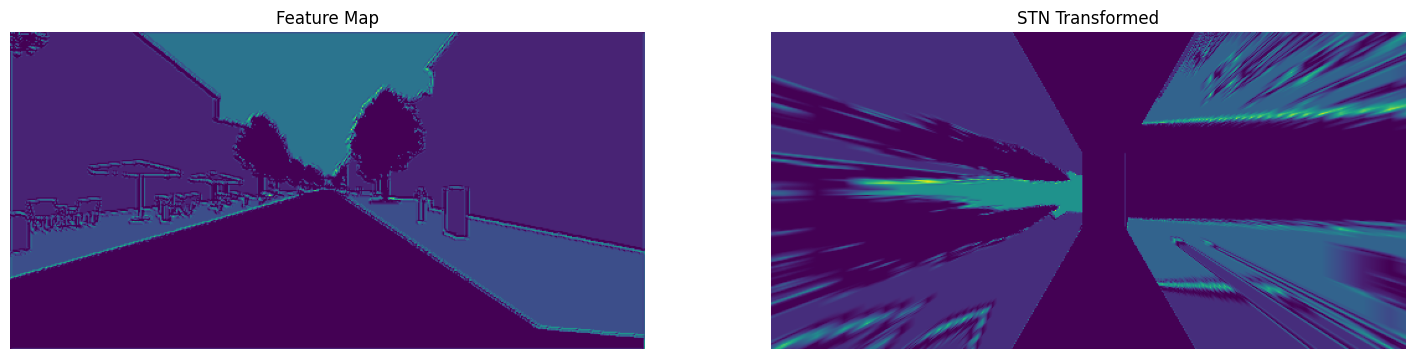

In [19]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize= (18, 12))

# plot Input images
plotImage(ax0, encoderOutput[0].detach().cpu().numpy()[0][12], "Feature Map")
plotImage(ax1, stnOutput.detach().cpu().numpy()[0][12], "STN Transformed")
plt.show()

# Implementing cross attention with global avg quries instead of mere concatenation

In [125]:
class Joiner(nn.Module):
    def __init__(self, inputShape, udepth, n_inputs, filters1, returnWarpedOutput=False):
        super(Joiner, self).__init__()
        self.n_inputs = n_inputs
        self.filters1 = filters1
        self.joiner_outputs = []
        self.joiner_layers = nn.ModuleList()
        self.depth_stn_layers = nn.ModuleList()
        self.returnWarpedOutput = returnWarpedOutput  
        self.attn_layers = nn.ModuleList()
        
        shape = list(inputShape)
        for d in range(udepth):
            layer = []
            filters = (2**d)*self.filters1
            warped_maps = []
            stn_layers = nn.ModuleList()
            for i in range(self.n_inputs):
                shape[-3] = filters
                shape[-2] = inputShape[-2]//(2**d)
                shape[-1] = inputShape[-1]//(2**d)
                stn_layers.append(STN(tuple(shape), H[i]))

            feature_dim = filters
            # print(feature_dim)
            attention_layer = nn.MultiheadAttention(embed_dim=feature_dim, num_heads=1, batch_first=True)
            self.attn_layers.append(attention_layer)
                
            self.depth_stn_layers.append(stn_layers)
            layer.append(nn.Conv2d(filters*n_inputs, filters, kernel_size=3, padding = 1))
            layer.append(nn.BatchNorm2d(filters))            
            layer.append(nn.ReLU(True))
            layer.append(nn.Conv2d(filters, filters, kernel_size=3, padding = 1))
            layer.append(nn.BatchNorm2d(filters))            
            layer.append(nn.ReLU(True))
            self.joiner_layers.append(nn.Sequential(*layer))
    
    def warpedOutput(self, flag):
        self.returnWarpedOutput = flag
    
    def forward(self, encoder_outputs):
        self.joiner_outputs = []
        warped_outputs = []
        
        for d in range(len(encoder_outputs[0])):
            filters = (2**d)*self.filters1
            
            warped_maps = []
            pooled_vectors = []
            for i in range(self.n_inputs):
                t = self.depth_stn_layers[d][i](encoder_outputs[i][d])
                pooled_vector_t = torch.mean(t, dim=(2, 3), keepdim=False)
                warped_maps.append(t)
                pooled_vectors.append(pooled_vector_t)
                # print("A",t.shape,pooled_vector_t.shape)
            t = torch.cat(warped_maps, dim=1) if self.n_inputs > 1 else warped_maps[0]
            pooled_vectors = torch.stack(pooled_vectors, dim=1) 
            attn_output, attn_weights = self.attn_layers[d](pooled_vectors, pooled_vectors, pooled_vectors)
            # print("B",t.shape, pooled_vectors.shape,attn_output.shape,attn_weights.shape)

            
            
            weighted_feature_maps = []
            for i in range(self.n_inputs):
                # Get attention weights for feature map i (from all views)
                attention_for_i = attn_weights[:, i, :]  # Shape: [batch_size, num_views]
                
                # Apply attention weights to each feature map
                weighted_fm = 0
                for j in range(self.n_inputs):
                    weighted_fm += attention_for_i[:, j].unsqueeze(1).unsqueeze(2).unsqueeze(3) * warped_maps[j]
                weighted_feature_maps.append(weighted_fm)
        
            # Sum all the weighted feature maps to get the final fused representation
            t = torch.cat(weighted_feature_maps, dim=1)
            # print("C",t.shape, pooled_vectors.shape,attn_output.shape,attn_weights.shape)
            # print()
            
            if(self.returnWarpedOutput):
                warped_outputs.append([x.cpu().detach().numpy() for x in warped_maps])            
            t = self.joiner_layers[d](t)
            self.joiner_outputs.append(t)
                
        if(self.returnWarpedOutput):
            return self.joiner_outputs, warped_outputs
        else:
            return self.joiner_outputs

In [126]:
joinerModule = Joiner(inputShape=(10,256,512), udepth=4, n_inputs=4, filters1=16, returnWarpedOutput=True).to(device)
joinerOutput, warped_outputs = joinerModule([encoderOutput for i in range(4)])   # simulate inputs from 4 cameras
print(f"Joiner module output = {[x.shape for x in joinerOutput]}")

Joiner module output = [torch.Size([1, 16, 256, 512]), torch.Size([1, 32, 128, 256]), torch.Size([1, 64, 64, 128]), torch.Size([1, 128, 32, 64])]


## Decoder 


In [127]:
class Decoder(nn.Module):
    def __init__(self, udepth, filters1):
        super(Decoder, self).__init__()
        self.udepth = udepth
        self.filters1 = filters1
        self.decoder_layers = nn.ModuleList()
        
        for d in reversed(range(self.udepth-1)):
            filters = (2**d)*self.filters1
            layer = []
            layer.append(nn.ConvTranspose2d(filters*2, filters, kernel_size=3, stride=2, padding=1, output_padding=1))
            layer.append(nn.Dropout2d(p=0.1))
            layer.append(nn.Conv2d(filters*2, filters, kernel_size=3, padding=1))
            layer.append(nn.BatchNorm2d(filters))            
            layer.append(nn.ReLU(True))
            layer.append(nn.Conv2d(filters, filters, kernel_size=3, padding=1))
            layer.append(nn.BatchNorm2d(filters))            
            layer.append(nn.ReLU(True))
            self.decoder_layers.append(nn.Sequential(*layer))

    def forward(self, joiner_outputs):
        t = joiner_outputs[-1]
        for d in reversed(range(self.udepth-1)):
            filters = (2**d)*self.filters1
            t = self.decoder_layers[self.udepth-2-d][0](t)
            t = torch.cat((joiner_outputs[d], t), dim=1)
            t = self.decoder_layers[self.udepth-2-d][1:](t)
        return t

In [128]:
decoderModule = Decoder(udepth=4, filters1=16).to(device)
decoderOutput = decoderModule(joinerOutput) 
print(f"decoderOutput module output = {decoderOutput.shape}")

decoderOutput module output = torch.Size([1, 16, 256, 512])


### Putting it together - UNetXST

In [129]:
class UNetXST(nn.Module):
    def __init__(self, inputShape, nInputs, nOutputClasses, udepth, filters1, returnWarpedOutput=False):
        super(UNetXST, self).__init__()
        self.inputShape = inputShape        
        self.nInputs = nInputs
        self.nOutputClasses = nOutputClasses
        self.udepth = udepth
        self.filters1 = filters1
        self.returnWarpedOutput = returnWarpedOutput

        self.encoder = nn.ModuleList([Encoder(self.inputShape, self.udepth, self.filters1) for i in range(nInputs)])
        self.joiner = Joiner(self.inputShape, self.udepth, self.nInputs, self.filters1, returnWarpedOutput=self.returnWarpedOutput)
        self.decoder = Decoder(self.udepth, self.filters1)

        self.prediction = nn.Sequential(
            nn.Conv2d(self.filters1, nOutputClasses, kernel_size=3, padding=1),
            nn.Softmax(dim=1)
        )

    def forward(self, inputs):
        encoder_outputs = []
        for i in range(self.nInputs):
            encoder_outputs.append(self.encoder[i](inputs[i]))
            
        if(self.returnWarpedOutput):
            joiner_output, warped_outputs = self.joiner(encoder_outputs)
            decoder_output = self.decoder(joiner_output)
            prediction = self.prediction(decoder_output)
            return prediction, warped_outputs
            
        else:
            joiner_output = self.joiner(encoder_outputs)
            decoder_output = self.decoder(joiner_output)
            prediction = self.prediction(decoder_output)
            return prediction            


In [130]:
model = UNetXST(inputShape =(10, 256, 512), nInputs= 4, nOutputClasses=10, udepth=4, filters1=16, returnWarpedOutput=True).to(device)
print(model)

UNetXST(
  (encoder): ModuleList(
    (0-3): 4 x Encoder(
      (encoder_layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
          (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (7): Dropout2d(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

## Training the model

In [131]:
def plot_training_results(df, model_name):
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.set_ylabel('trainLoss', color='tab:red')
    ax1.plot(df['epoch'].values, df['trainLoss'].values, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('validationLoss', color='tab:blue')
    ax2.plot(df['epoch'].values, df['validationLoss'].values, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.suptitle(f'{model_name} Training, Validation Curves')
    plt.show()

In [132]:
class meanIoU:
    """ Class to find the mean IoU using confusion matrix approach """    
    def __init__(self, num_classes):
        self.iou_metric = 0.0
        self.num_classes = num_classes
        # placeholder for confusion matrix on entire dataset
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))

    def update(self, y_preds, labels):
        predicted_labels = torch.argmax(y_preds, dim=1)
        batch_confusion_matrix = self._fast_hist(labels.numpy().flatten(), predicted_labels.numpy().flatten())
        self.confusion_matrix += batch_confusion_matrix
    
    def _fast_hist(self, label_true, label_pred):
        mask = (label_true >= 0) & (label_true < self.num_classes)
        hist = np.bincount(
            self.num_classes * label_true[mask].astype(int) + label_pred[mask],
            minlength=self.num_classes ** 2,
        ).reshape(self.num_classes, self.num_classes)
        return hist

    def compute(self):
        hist = self.confusion_matrix
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu)
        return mean_iu

    def reset(self):
        self.iou_metric = 0.0
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))

In [133]:
def evaluate_model(model, dataloader, criterion, metric_class, device):
    model.eval()
    total_loss = 0.0
    metric_object = metric_class(NUM_CLASSES)

    with torch.no_grad():
        for inputs,labels in tqdm(dataloader, total=len(dataloader)):
            inputs = [x.to(device) for x in inputs]
            labels = labels.to(device)            
            _, labels = labels.max(dim=1) # converting to single channel output
            y_preds = model(inputs)

            # calculate loss
            loss = criterion(y_preds, labels)
            total_loss += loss.item()

            # update batch metric information            
            metric_object.update(y_preds.cpu().detach(), labels.cpu().detach())

    evaluation_loss = total_loss / len(dataloader)
    evaluation_metric = metric_object.compute()
    return evaluation_loss, evaluation_metric

In [134]:
import pandas as pd
from tqdm import tqdm

def train_validate_model(model, num_epochs, model_name, criterion, optimizer, 
                         device, dataloader_train, dataloader_valid, 
                         metric_class, metric_name, lr_scheduler = None):
    # initialize placeholders for running values
    results = []    
    min_val_loss = np.Inf
    len_train_loader = len(dataloader_train)

    # move model to device
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        model.train()
        train_loss = 0.0
        for inputs,labels in tqdm(dataloader_train, total=len_train_loader):
            inputs = [x.to(device) for x in inputs]
            labels = labels.to(device)            
            _, labels = labels.max(dim=1) # converting to single channel output
            
            # Forward pass
            y_preds, warped = model(inputs)
            loss = criterion(y_preds, labels)
            train_loss += loss.item()
              
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # adjust learning rate
            if lr_scheduler is not None:
                lr_scheduler.step()
            
        # compute per batch losses, metric value
        train_loss = train_loss / len(dataloader_train)
        validation_loss, validation_metric = evaluate_model(
                        model, dataloader_valid, criterion, metric_class, device)

        print(f'Epoch: {epoch+1}, trainLoss:{train_loss:6.5f}, validationLoss:{validation_loss:6.5f}, {metric_name}:{validation_metric: 4.2f}')
        
        # store results
        results.append({'epoch': epoch, 'trainLoss': train_loss, 'validationLoss': validation_loss, f'{metric_name}': validation_metric})
        
        # if validation loss has decreased, save model and reset variable
        if validation_loss <= min_val_loss:
            min_val_loss = validation_loss
            torch.save(model.state_dict(), f"{model_name}.pt")

    # plot results
    results = pd.DataFrame(results)
    plot_training_results(results, model_name)
    return results

In [135]:
# class weight is inversely proportional to % of class in entre training dataset
weights = np.array([0.98684351, 2.2481491, 10.47452063, 4.78351389, 7.01028204, 8.41360361, 10.91633349, 2.38571558, 1.02473193, 2.79359197])
normalizedWeights = (weights / np.sum(weights))
normalizedWeights = torch.from_numpy(normalizedWeights).float().to(device)

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts

criterion = nn.CrossEntropyLoss(weight=normalizedWeights)

# MODEL HYPERPARAMETERS
N_EPOCHS = 2
NUM_CLASSES = 10
MAX_LR = 1e-3
MODEL_NAME = 'UNetXST_CosAnneal_1e-3'

# create model, optimizer, lr_scheduler and pass to training function
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0 = int(len(trainLoader) * float(N_EPOCHS)/10), eta_min=3e-4)


_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer, 
                         device, trainLoader, valLoader, meanIoU, 'meanIoU',
                         lr_scheduler = scheduler)

Starting 1 epoch ...


  7%|▋         | 132/2000 [00:40<09:06,  3.42it/s]

In [ ]:
# path = "unetxst/UNEtXST_CosAnneal_1-3.pt"
path = "/data/input/unetxst-model/UNetXST_pretrained_55ep.pt"
model.load_state_dict(torch.load(path))

In [ ]:
# One-hot encoding -> color mapping Decoders
inputDecoder = torch.from_numpy(np.array([x[0] for x in inputPalette])).to(device)
outputDecoder = torch.from_numpy(np.array([x[0] for x in outputPalette])).to(device)

In [ ]:
# Placeholder for storing output
output = {}
for view in ['FRONT', 'LEFT', 'REAR', 'RIGHT', 'BEV_PREDS']:
    output[f"{view}"] = []
    
# redefine validation loader, but with shuffle set to False
valLoader = DataLoader(valSet, batch_size=8, shuffle=False, num_workers=2)

with torch.no_grad():
    for inputs,labels in tqdm(valLoader, total=len(valLoader)):
        inputs = [x.to(device) for x in inputs]
        y_preds, warped = model(inputs)
        labels = labels.to(device)
        
        # One-hot encoding -> Class Index -> RGB image based on color map
        decodedInputs = [inputDecoder[torch.argmax(x, dim=1)].cpu().detach().numpy() for x in inputs]
        decodedOutputs = outputDecoder[torch.argmax(y_preds, dim=1)].cpu().detach().numpy()
#         decodedLabels = outputDecoder[torch.argmax(labels, dim=1)].cpu().detach().numpy()
        
        # store each sample output as separate item
        for i in range(decodedInputs[0].shape[0]):
            output['FRONT'].append(decodedInputs[0][i])
            output['LEFT'].append(decodedInputs[1][i])
            output['REAR'].append(decodedInputs[2][i])
            output['RIGHT'].append(decodedInputs[3][i])
            output['BEV_PREDS'].append(decodedOutputs[i])
#             output['BEV_PREDS'].append(decodedLabels[i])

In [ ]:
import matplotlib.animation as animation

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)

In [ ]:
fig, axes = plt.subplot_mosaic([['FRONT', 'LEFT', 'REAR', 'RIGHT'], ['BEV_PREDS', 'BEV_PREDS', 'BEV_PREDS', 'BEV_PREDS']],
                               height_ratios=[0.4, 0.6], figsize=(10, 8))

imgHandles = []
for title,ax in axes.items():
    imgHandles.append(ax.imshow(np.random.rand(256,512)))
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()

def run(index, data, imgHandles):
    for i,view in enumerate(['FRONT', 'LEFT', 'REAR', 'RIGHT', 'BEV_PREDS']):
        imgHandles[i].set_data(output[view][index])
    return imgHandles

ani = animation.FuncAnimation(fig, run, len(output['FRONT']), fargs=(output, imgHandles), blit=True, interval=10, repeat=False)

In [ ]:
ani.save('BEV_output.mp4', writer=writer, dpi=100)

## BEV Feature Visualization

In [ ]:
warped[0][0][0].shape

In [ ]:
fig, axes = plt.subplot_mosaic([['FRONT', 'LEFT', 'REAR', 'RIGHT'], 
                                ['FRONT_BEV', 'LEFT_BEV', 'REAR_BEV', 'RIGHT_BEV'], 
                                ['BEV_PREDS', 'BEV_PREDS', 'BEV_PREDS', 'BEV_PREDS']],
                               height_ratios=[0.4, 0.3, 0.4], figsize=(18,12))

for title, ax in axes.items():
    ax.axis('off')

for view in ['FRONT', 'LEFT', 'REAR', 'RIGHT', 'BEV_PREDS']:
    axes[view].imshow(output[view][-1])
    axes[view].set_title(view)

axes['FRONT_BEV'].imshow(warped[0][0][-1][0], cmap='inferno')
axes['LEFT_BEV'].imshow(warped[0][1][-1][0], cmap='inferno')
axes['REAR_BEV'].imshow(warped[0][2][-1][0], cmap='inferno')
axes['RIGHT_BEV'].imshow(warped[0][3][-1][0], cmap='inferno')
plt.tight_layout()
plt.show()